# CS229-EE242 - Spring 2025 - Homework 1

# Due: Friday, April 25, 2025 @ 11:59pm

### Maximum points: 50 pts


## Submit your solution to elearn:
1. Submit a single PDF to **HW1**
2. Submit your jupyter notebook to **HW1-code**

**Both code and pdf need to show code outputs. See the additional submission instructions at the end of this notebook**


## Enter your information below:

### Your Name (Yurui Huang):

### Your student ID (yhuan406):
    
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>


## Academic Integrity
Each assignment should be done  individually. You may discuss general approaches with other students in the class, and ask questions to the TAs, but  you must only submit work that is yours . If you receive help by any external sources (other than the TA and the instructor), you must properly credit those sources, and if the help is significant, the appropriate grade reduction will be applied. If you fail to do so, the instructor and the TAs are obligated to take the appropriate actions outlined at http://conduct.ucr.edu/policies/academicintegrity.html . Please read carefully the UCR academic integrity policies included in the link.


### PyTorch Materials:

If you're not familiar with PyTorch, please review the introductory tutorials before proceeding with this notebook:

- [PyTorch Beginner Tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html)
- [PyTorch Neural Networks Tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

You can also refer to this notebook for an introduction:  
[PyTorch Tutorial - CS231N Spring 2024](https://colab.research.google.com/drive/1FERNv6t8xpX9Nly_JdnePWEPllI7F3Fx?usp=sharing)

# Vision Transformer (ViT) Homework

## Overview

In this homework, we will build and train a Vision Transformer (ViT)[1] from scratch. You will implement key components, including **patch embedding**, **normalizations**, and **self-attention layers**, and **train** the model on an image classification task. Additionally, you will train the model on randomly assigned labels to analyze its generalization behavior.

<!-- <p align="center">
  
</p> -->

<p align="center">
  <img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png" />
  <img src="https://theaisummer.com/static/aa65d942973255da238052d8cdfa4fcd/7d4ec/the-transformer-block-vit.png" alt="Vision Transformer Architecture" />
</p>

<p align="center">
  Figure 1. Vision Transformer Architecture
</p>


### Expected Outcomes

- Understanding of Vision Transformer architecture.
- Insights into model memorization and generalization behavior.

### References

[1] Dosovitskiy, Alexey, et al. "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale." *International Conference on Learning Representations (ICLR)*, 2020.  


## Read *all* cells carefully and answer all parts


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset


from torch.utils.data import DataLoader
from torchvision import datasets, transforms


## Question 1. Implement and train the MLP Block [8 pts]


### Question 1.1 Implement the MLP Block [3 pts]

The MLP accepts input as a vector and contains two layers with a GELU non-linearity.

**TODO**:
Complete the implementation of the MLPBlock class. You should define the layers in the constructor (__init__) and implement the forward method (forward). The module will have two linear layers and activation layer in between.

**Hints:**
- **Linear Layers**: Use `nn.Linear` to map from `in_dim` → `hidden_dim`, then from `hidden_dim` → `out_dim`.
- **Activation**: Insert an activation function (e.g., `nn.ReLU()` or `nn.GELU()`) between the linear layers.
- **Forward**: Apply the layers sequentially: first the **linear layer**, then **activation**, then the **second linear layer**.


In [ ]:
class MLPBlock(nn.Module):
  def __init__(self, in_dim, hidden_dim, out_dim):
    """
    Initialize the MLP block with two linear layers and an activation function.

    Args:
        in_dim (int): Input feature dimension.
        hidden_dim (int): Hidden layer dimension.
        out_dim (int): Output feature dimension.
    """
    super().__init__()
    self.fc1 = nn.Linear(in_dim, hidden_dim)
    # self.act = nn.ReLU()
    self.act = nn.GELU()
    self.fc2 = nn.Linear(hidden_dim, out_dim)

  def forward(self, x):
    """
    Forward pass through the MLP block.

    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, in_dim).

    Returns:
        torch.Tensor: Output tensor of shape (batch_size, out_dim).
    """
    x = self.fc1(x)

    x = self.act(x)

    x = self.fc2(x)

    return x


use MLP block as a shallow structure that process X -> layer ->activation ->repeat(layer,activation) -> output

This way it can do different tasks classfication/regression.

embed it MLP classifer and Vit Later

In [ ]:
class MLPClassifier(nn.Module):
  def __init__(self, input_dim=3072, hidden_dim=100, num_classes=10):
    super().__init__()
    # re-use the MLP block sturect. 2layer nneural netWrok
    self.mlp = MLPBlock(input_dim, hidden_dim, num_classes)

  def forward(self, x):
    # since the MLP only accept vecotrlike input,
    # we flat the cifar10 image with batch size and vector array
    x = x.view(x.size(0), -1)
    return self.mlp(x)

### Question 1.2 Train the MLP Block [5 pts]

In this section, we will train a simple **2-layer MLP (Multilayer Perceptron)** for image classification using the CIFAR-10 dataset. The model will incorporate a GeLU (Gaussian Error Linear Unit) activation function, which is commonly used in transformer architectures.

**Steps:**
1. **Dataset**: We'll use the CIFAR-10 dataset, which contains 60,000 32x32 color images in 10 classes.
2. **Model**: Model: The model will be a basic 2-layer MLP, with a GeLU activation function between the layers
3. **Training**: Train the model for some epochs using Cross-Entropy loss and Adam optimizer.
4. **Evaluation**: Evaluate the model's performance on the test set.

#### Dataset and dataloading

In the code below, we will define the dataset and dataloader, which will be used in our training loop.

Note that we are using `batch_size = 16`, you can use the same batch size or play with this number.



In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

#### Define the model [1 pts]

In this section, we will define a classification model using a simple 2-layer MLP. The first layer transforms the input, followed by a GeLU activation, and the second layer produces the final output for classification.

**Hints:**
- The input dimension is the total number of pixels in the image, including all color channels. For CIFAR-10, `in_dim = 32 * 32 * 3 = 3072`.
- Use `.view(x.size(0), -1)` to flatten the image into a 1D vector for the MLP.
- The size of the hidden layer (`hidden_dim`) is a hyperparameter. You can experiment with different sizes to find what works best.
- The size of `out_dim` will be 10, because we want to estimate a probability vector with 10 classes.






In [ ]:
model = MLPClassifier(input_dim=3072, hidden_dim=300, num_classes=10)

#### Implement training loop [2 pts]

In this section, you will implement the training loop for the MLP model. Below is a basic structure for the training process. We have implemented some parts and you will fill in the rest.

- **Training Loop:**: Implement the loop to train the model for some epochs, calculate the loss, and update the model parameters.

- **Evaluation**: Compute and store `test_accuracy` and `train_accuracy` per each epoch.


**You should get at least 50% accuracy on the test data.**


In [ ]:
# Define the optimizer and loss function
learning_rate = 2e-4
num_epochs = 20
# num_epochs = 2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
if torch.cuda.is_available():
  model.cuda()

test_accuracy = []
train_accuracy = []

# Training loop
for epoch in range(num_epochs):
    model.train()

    running_loss = 0

    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        # Move data to device if cuda is available
        if torch.cuda.is_available():
          inputs, targets = inputs.cuda(), targets.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # TODO:
        # Fill the following sections
        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward propagation on the loss
        loss.backward()

        # Update model parameters using optimizer
        optimizer.step()

        running_loss += loss.item()

    # TODO
    # Compute training accuracy
    predicted = outputs.argmax(dim=1)
    correct_train += (predicted == targets).sum().item()
    total_train += targets.size(0)

    acc_train = 100 * correct_train / total_train
    train_accuracy.append(acc_train)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Acc: {acc_train:.2f}%')

    # Evaluation on the test set
    model.eval()  # Set model to evaluation mode

    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            # Move data to device if cuda is available
            if torch.cuda.is_available():
              inputs, targets = inputs.cuda(), targets.cuda()

            # TODO:
            # Fill the following sections

            # Forward pass
            outputs = model(inputs)

            # Get predictions
            predicted = outputs.argmax(dim=1)


    # TODO:
    # compute accuracy on the test set
    correct_test += (predicted == targets).sum().item()
    total_test += targets.size(0)

    accuracy = 100 * correct_test / total_test
    test_accuracy.append(accuracy)
    print(f'Accuracy on the test set: {accuracy:.2f}%')


Epoch [1/20], Loss: 1.7773, Train Acc: 37.50%
Accuracy on the test set: 50.00%
Epoch [2/20], Loss: 1.6240, Train Acc: 43.75%
Accuracy on the test set: 37.50%
Epoch [3/20], Loss: 1.5678, Train Acc: 37.50%
Accuracy on the test set: 37.50%
Epoch [4/20], Loss: 1.5312, Train Acc: 31.25%
Accuracy on the test set: 31.25%
Epoch [5/20], Loss: 1.5057, Train Acc: 25.00%
Accuracy on the test set: 62.50%
Epoch [6/20], Loss: 1.4899, Train Acc: 31.25%
Accuracy on the test set: 50.00%
Epoch [7/20], Loss: 1.4733, Train Acc: 87.50%
Accuracy on the test set: 50.00%
Epoch [8/20], Loss: 1.4578, Train Acc: 62.50%
Accuracy on the test set: 62.50%
Epoch [9/20], Loss: 1.4470, Train Acc: 75.00%
Accuracy on the test set: 56.25%
Epoch [10/20], Loss: 1.4290, Train Acc: 43.75%
Accuracy on the test set: 50.00%
Epoch [11/20], Loss: 1.4241, Train Acc: 68.75%
Accuracy on the test set: 50.00%
Epoch [12/20], Loss: 1.4177, Train Acc: 56.25%
Accuracy on the test set: 56.25%
Epoch [13/20], Loss: 1.4091, Train Acc: 56.25%
Ac

#### 1.2.3 Plot training and test accuracy [2 pts]

In your training loop above, make sure to calculate training accuracy per epoch and append it to the `train_accuracy` and `test_accuracy` variables.

We have written the plotting code in the cell below.

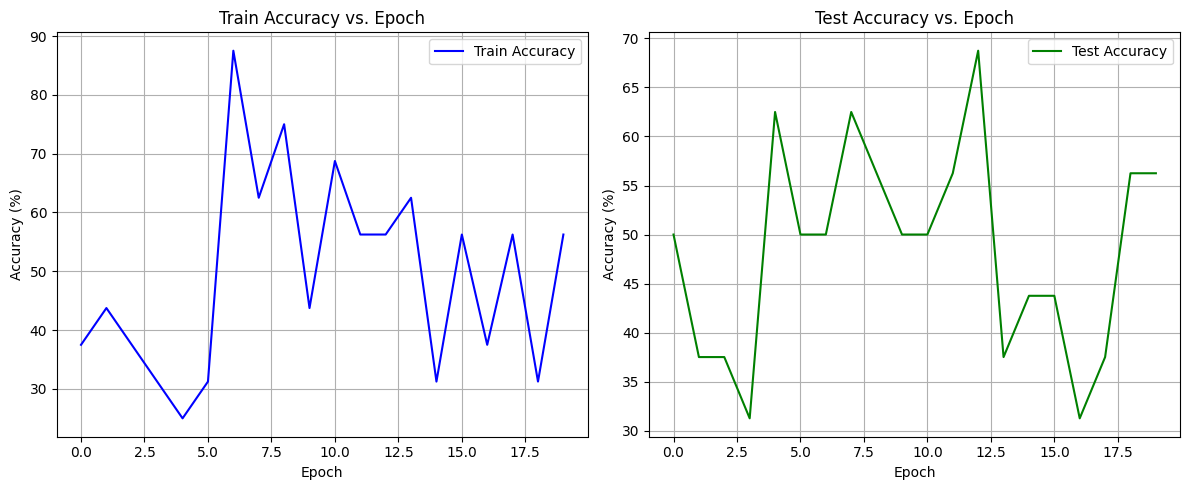

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(train_accuracy, label='Train Accuracy', color='blue')
axs[0].set_title('Train Accuracy vs. Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(test_accuracy, label='Test Accuracy', color='green')
axs[1].set_title('Test Accuracy vs. Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

##obs

With the MLP model, it process the flatten version of image(3*32*32 = 3072 features). Despite due to its structure, plays linaer regression, only find the hidden patttern behind numbers. Unable to previous values nor capture local features. It still showed a capability to make better prediction. higher than random guess of 10%

 notes

I tried some values of hidden neurons(20,100,200,300,1000). As i increase the hidden neuron increase the MLP's performence. Howvever, due to time issuee, not hypertunnig it here. The test accuracy indeed can reach 50% if the complexity is big enough

## Question 2. Implement Patch Embedding Layer [5 pts]

Now, we will implement a patch embedding layer that divides each input image into fixed-size patches. Then we will embed each patch independently into a vector (aka token). All the tokens corresponding to all the patches will then be used inputs to the transformer.

**Hints:**
- **Patch Size:** The image is typically divided into square patches of size `(patch_size, patch_size)`. For example, if the image is 224x224 and the patch size is 16, there will be 224/16 = 14 patches along each dimension, resulting in `N=14 x 14 = 196` patches. CIFAR images are small (32 x 32 pixels), so you may want to use a smaller patch size.

- **Conv2D**: Suppose we want to divide an `3 x H x W` image into `N` patches (each of size `3 x p x p`) and then transform each patch into a `d`-dimensional vector (token). In the code below, we refer to `d` as `embed_dim` or `hidden_dim`. We can do all of this using a single convolutional layer (nn.Conv2d) with `d` channels. The kernel size should be equal to the patch size, and the stride should be the same to avoid overlap. The resulting `(d x H/p x W/p)` tensor will have `d` channels, each with `(H/p x W/p)` spatial features.



- **Flatten**: After embedding the patches, we can flatten them to create a sequence of patch embeddings. This will be done across the last two dimensions (height, width) after convolution. \\
Suppose we are using a batch of shape `(batch_size, 3, H, W)`, after Conv2D and Flatten, we should get a tensor of shape `(batch_size, d, N)`.

- **Transpose**: After flattening, transpose the output to `(batch_size, num_patches, hidden_dim)` or `(batch_size, N, d)` for the final format.

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, in_channels, embed_dim):
        """
        Initialize the Patch Embedding layer.

        Args:
            patch_size (int): Size of each patch (patch_size x patch_size).
            in_channels (int): Number of input channels (This will be 3 for RGB images).
            embed_dim (int): Dimension of the embedding for each patch.
        """
        super().__init__()
        # TODO: Define the layers here
        self.patch_size = patch_size

        # use Conv2D to embed patches
        self.proj = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim,kernel_size=patch_size,stride=patch_size)

    def forward(self, x):
        """
        Forward pass through the PatchEmbedding layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_patches, embed_dim).

            num_patches = (height * width) / (patch_size * patch_size)
        """
        # TODO: Implement the forward pass
        # embed patches
        x = self.proj(x)
        # print(x,"xxxxxx conv2d projctn")

        # After embedding the patches, we can flatten them to create a sequence of patch embeddings.
        x = x.flatten(2)
        # print(x,"xxxxxx flat")
        x = x.transpose(1, 2)
        # print(x,"xxxxxx flat")
        return x


test sample verify shape and results

In [ ]:
images, labels = next(iter(test_loader))  #16 3 32 32, batch channel, Height, width
patch_size = 4 # 32/4 = 8, total 8 * 8 =64 patches
embed_dim = 64 # ,ap the each patch into a vector has 64 numbers. Tokenize, summarize patch info
patch_embed = PatchEmbedding(patch_size=patch_size, in_channels=3, embed_dim=embed_dim)

output = patch_embed(images)

print(images.shape)
print(output.shape)

torch.Size([16, 3, 32, 32])
torch.Size([16, 64, 64])



codes from generative AI such as coplite
see the patched image


In [ ]:
def unnormalize(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
  for c in range(3):
    img[c] = img[c] * std[c] + mean[c]
  return img

def visualize_patches(image, patch_size=4):
  image = image.permute(1, 2, 0)
  H, W, C = image.shape
  fig, axs = plt.subplots(H//patch_size, W//patch_size)

  for i in range(0, H, patch_size):
    for j in range(0, W, patch_size):
      row = i//patch_size
      col = j//patch_size
      patch = image[i:i+patch_size, j:j+patch_size, :]

      axs[row, col].imshow(patch)
      axs[row, col].axis('off')

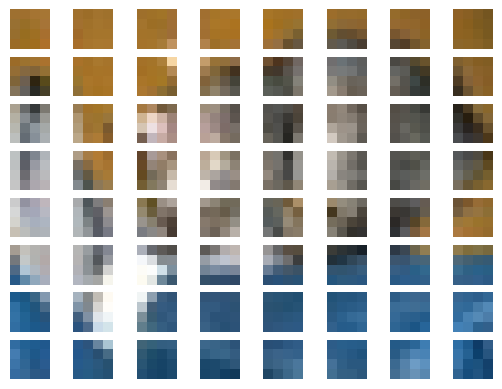

In [ ]:
sample_image = unnormalize(images[0].clone())
visualize_patches(sample_image, patch_size=4)


## Question 3. Implement Multi-Head Self-Attention (MHSA) [10 pts]

In this task, we will implement a Multi-Head Self-Attention (MHSA) layer. As the name suggests, MHSA has self attention with multiple heads.

**Self-Attention** module seeks to combine the input sequence of tokens (based on some similarity metric) to generate a set of output tokens. The key equations for self-attention can be written as follows.

For a given $N\times d$ input token matrix $Z$, with $N$ tokens each of dimension $d$, we generate Query, Key, and Value matrices that can be written as
  $$
  Q = Z W_Q, \quad K = Z W_K, \quad V = Z W_V,
  $$
where  $W_Q, W_K, W_V$ are weight matrices that we learn for the query, key, and value projections. You can implement each of them as a linear layer.
  
For simplicity, we can assume that each of the projection matrices have same size (e.g., $d\times d$ matrices that map each $d$-dim token to $d$-dim space; shortly we will see that in the case of multiple heads we prefer to use a reduced dimension for each head).

**Scaled Dot-Product Attention** is computed as

  $$
  \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q K^T}{\sqrt{d}}\right) V
  $$

  Where:
  - $d$ is the embedding dimension of tokens in the Q, K, and V matrices. In the code, we also refer to it as `hidden_dim`.
  - The softmax function is applied over the rows of $\frac{Q K^T}{\sqrt{d}}$.

**Multi-Head Selft Attention (MHSA)**: As the saying goes multiple heads are better than one. In practice, we use multiple heads to perform a separate attention operation on each heads with a different set of learned projections.

Let us assume that we want to use $h$ heads, all of which receive the same input tokens $Z$ and provide a set of outputs that we denote as $(\text{head}_1,\ldots, \text{head}_h)$. We compute each output head as

$$\text{head}_i = \text{Attention}(Q_i, K_i, V_i),$$

where $Q_i=ZW^i_Q, K_i = Z W^i_K, V_i = ZW^i_V$ are the (Q, K, V) for head i with learnable weight matrices: $W_Q^i, W_K^i, W_V^i$.

The choice of embedding dimension for each head is in our control, but for simplicity we use $d_k = d/h$ as the embedding dimension for each head. For this reason, we prefer to use $h$ that divides $d$ into an integer.

To compute the final MHSA output, we concatednate the output of all the heads and apply an output linear transform to get a $N\times d$ output token matrix as
  
  $$
  \text{MHSA}(Z) = \text{concat}(\text{head}_1, \dots, \text{head}_h) W_O,
  $$
where $W_O$ denotes the $d\times d$ output transform matrix.

In [ ]:
class MHSA(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        """
        Multi-Head Self-Attention Layer.

        Args:
            hidden_dim (int): Total embedding dimension (d).
            num_heads (int): Number of attention heads (h).
        """
        super(MHSA, self).__init__()
        # TODO: Define the layers here
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        # initialize the queery, key and value matrix
        self.q_proj = nn.Linear(hidden_dim, hidden_dim)

        self.k_proj = nn.Linear(hidden_dim, hidden_dim)

        self.v_proj = nn.Linear(hidden_dim, hidden_dim)

        self.out_proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        """
        Forward pass through the Multi-Head Self-Attention (MHSA) layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_patches, hidden_dim).

        Returns:
            torch.Tensor: Output tensor after applying multi-head attention.
        """
        B, N, D = x.shape
        H = self.num_heads
        d_k = self.head_dim

        # TODO:
        # 1. Apply linear projections to input x for to obtain Q, K, and V.
        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)

        # 2. Compute attention scores for each head.
        Q = Q.view(B, N, H, d_k).transpose(1, 2)
        K = K.view(B, N, H, d_k).transpose(1, 2)
        V = V.view(B, N, H, d_k).transpose(1, 2)

        # 3. Apply attention to V: output = attention @ V
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (d_k ** 0.5)
        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)

        # 4. Concatenate outputs from all heads and apply final linear projection
        out = out.transpose(1, 2).contiguous().view(B, N, D)
        x = self.out_proj(out)
        return x


test a sample

In [ ]:
images, labels = next(iter(test_loader))

patch_size = 4
embed_dim = 128
patch_embed = PatchEmbedding(patch_size=patch_size, in_channels=3, embed_dim=embed_dim)

patch_embeddings = patch_embed(images)
print("patch_embeddings ", patch_embeddings.shape)

num_heads = 8
mhsa = MHSA(hidden_dim=embed_dim, num_heads=num_heads)
mhsa_output = mhsa(patch_embeddings)
print("mhsa_output ", mhsa_output.shape)


patch_embeddings  torch.Size([16, 64, 128])
mhsa_output  torch.Size([16, 64, 128])


## Question 4. Build the Vision Transformer Model [10 pts]



### 4.1 Implement the Encoder Module [5 pts]

The EncoderLayer is a core building block of the Vision Transformer (ViT). Each encoder layer consists of two key components: Multi-Head Self-Attention (MHSA) and a Multi-Layer Perceptron (MLP). Each of these components is followed by residual connections and [layer normalization](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#layernorm) (take a look at Figure 1 for visual reference).

The `attn_drop_out` argument controls the dropout rate applied to the attention weights. If you set `attn_drop_out=0`, it should disable attention dropout. Use `nn.Dropout` to implement it.




In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, mlp_hidden_dim, attn_drop_out=0):
        """
          An encoder layer in the Vision Transformer (ViT).

          Args:
              hidden_dim (int): The dimension of the embedding space ($d$).
              num_heads (int): The number of attention heads in the Multi-Head Self-Attention (MHSA) layer.
              mlp_hidden_dim (int): Hidden dimension of the MLP block.
              attn_drop_out (float): Dropout rate applied to the attention weights. Set to 0 to disable dropout and allow full attention flow during training.
        """
        super(EncoderLayer, self).__init__()

        # TODO define Multi-Head Self-Attention (MHSA)
        self.mhsa = MHSA(hidden_dim=hidden_dim, num_heads=num_heads)

        # dropout
        # self.attn_dropout = nn.Dropout(attn_drop_out) if attn_drop_out > 0 else nn.Identity()
        self.attn_dropout = nn.Dropout(attn_drop_out)

        # TODO define Layer normalization
        self.norm1 = nn.LayerNorm(hidden_dim)

        # TODO define MLP
        self.mlp = MLPBlock(in_dim=hidden_dim, hidden_dim=mlp_hidden_dim, out_dim=hidden_dim)

        # TODO define a second Layer normalization
        self.norm2 = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        """
        Forward pass through the Encoder layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_patches, embed_dim).

        Returns:
            torch.Tensor: Encoder output
        """
        # TODO:
        # 1. Apply MHSA to x
        x_norm = self.norm1(x)
        attn_out = self.attn_dropout(self.mhsa(x_norm))

        # 2. Perform layer normalization with residual connection
        x = x + attn_out

        # 3. Perform projection using MLP with residual connection
        x_norm = self.norm2(x)
        mlp_out = self.mlp(x_norm)

        # 4. Compute output by performing second layer normalization
        x = x + mlp_out

        return x


test sample

In [ ]:
images, labels = next(iter(test_loader))

patch_size = 4
embed_dim = 128
patch_embed = PatchEmbedding(patch_size=patch_size, in_channels=3, embed_dim=embed_dim)

patch_embeddings = patch_embed(images)
print("patch_embeddings ", patch_embeddings.shape)

num_heads = 8
mlp_hidden_dim = 256
attn_drop_out = 0.1
encoder = EncoderLayer(hidden_dim=embed_dim, num_heads=num_heads, mlp_hidden_dim=mlp_hidden_dim, attn_drop_out=attn_drop_out)
encoder_output = encoder(patch_embeddings)
print("encoder_output:", encoder_output.shape)


patch_embeddings  torch.Size([16, 64, 128])
encoder_output: torch.Size([16, 64, 128])


### 4.2 Build the Vision Transformer Model [5 pts]

We have almost everything ready to build a vision transformer. We need to take care of two things: 1) positional encoding; 2) `cls` embedding token

**Positional encoding.** Note that the attention mechanism is permuation invariant (i.e., we can shuffle the patches in a random order and get the same output from the attention layers). To encode positional information in the patches, we add position embedding vectors to all the input embedded patches. The position embedding vectors have the same dimension ($d$) as the embedded patches. A common choice for position embedding is the sinusoidal embedding, but below we will use learnable embedding.

**CLS token.** As we discussed in the class that we usually prepend an extra learnable `cls` token to the input embedding (as shown in Figure 1). We then use the output token corresponding to the `cls` token at the last layer to perform the classification. The total number of tokens in the sequence will therefore be `num_patches+1`.





In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, num_heads, num_layers, hidden_dim, num_classes, patch_size, in_channels, img_size, mlp_hidden_dim, attn_drop_out):
        """
        Vision Transformer (ViT) model.

        Args:
            num_heads (int): The number of attention heads in each Multi-Head Self-Attention (MHSA) layer.
            num_layers (int): The number of transformer encoder layers to be stacked in the model.
            hidden_dim (int): The dimension of the embedding space ($d$).
            num_classes (int): The number of output classes for the classification task.
            patch_size (int): The size of the patches that the input image will be divided into (e.g., 16x16).
            in_channels (int): The number of channels of the input image (e.g, 3 for RGB images).
            img_size (int): The size of the input image (e.g., 224 for 224x224 images).
            mlp_hidden_dim (int): The hidden dimension of the MLP block.
            attn_drop_out (float): Dropout rate applied to the attention weights. Set to 0 to disable dropout and allow full attention flow during training.

        """
        super(VisionTransformer, self).__init__()

        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim)) # A class Token (Learnable Parameter)

        # Learnable Position embedding
        seq_length = (img_size // patch_size) ** 2 + 1
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_dim).normal_(std=0.02))

        # Complete the rest of the layers
        # TODO: Create a Patch Embedding Layer
        self.patch_embed = PatchEmbedding(patch_size, in_channels, hidden_dim)

        # TODO: Create `num_layers` Encoder Layers
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(hidden_dim, num_heads, mlp_hidden_dim, attn_drop_out)
            for _ in range(num_layers)
        ])

        # TODO: Create a Final Linear Layer for Classification
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        """
        Forward pass through the ViT model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_patches, embed_dim).

        Returns:
            torch.Tensor: ViT output
        """
        # TODO
        # 1. Apply patch embedding and concatenate class token
        B = x.size(0)
        x = self.patch_embed(x)

        # 2. Add position encoding and perform forward pass through each encoder layer
        # B 1 D
        cls_tokens = self.cls_token.expand(B, -1, -1)
        # B,N+1,D
        x = torch.cat((cls_tokens, x), dim=1)

        # 3. Extract the class token's output for classification and pass it through the final classification layer
        x = x + self.pos_embedding  # (B, N+1, D)

        # 4. Return output
        for encoder in self.encoder_layers:
            x = encoder(x)
        cls_output = x[:, 0]
        logits = self.fc(cls_output)
        return logits


TEST

In [ ]:
images, labels = next(iter(test_loader))

vit = VisionTransformer(
    num_heads=4,
    num_layers=6,
    hidden_dim=128,
    num_classes=10,
    patch_size=4,
    in_channels=3,
    img_size=32,
    mlp_hidden_dim=256,
    attn_drop_out=0.1
)

output = vit(images)
print("Output shape", output.shape)


Output shape torch.Size([16, 10])


## Question 5. Training and Evaluation [17 pts]

### 5.1 Image classification [10 pts]

In this section, we will implement a simple image classification model using the CIFAR-10 dataset. The model will be a **2-layer Vision Transformer (ViT)**, where the images are divided into patches, and a Transformer encoder is used for classification.

**Steps:**
1. **Dataset**: We'll use the CIFAR-10 dataset, which contains 60,000 32x32 color images in 10 classes.
2. **Model**: A basic 2-layer Vision Transformer (ViT) with patch embedding, Transformer layers, and a classification head.
3. **Training**: Train the model for 5 epochs using Cross-Entropy loss and Adam optimizer.
4. **Evaluation**: Evaluate the model's performance on the test set.


#### Data loading and training setup

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

#### 5.1.1 Define the model [3 pts]

In this section, you will create an object of the VisionTransformer class that you implemented in **Question 4.**

Use the following parameters to instantiate the model:
- `num_heads`: Number of attention heads in each transformer layer ($h$).
- `num_layers`: Number of transformer layers.
- `hidden_dim`: The dimensionality of the embedding space ($d$).
- `num_classes`: The number of output classes (CIFAR-10 has 10 classes).
- `patch_size`: The size of the patches to divide the image.
- `in_channels`: The number of input channels (3 for RGB images).
- `img_size`: The size of the input images (32x32 for CIFAR-10).
- `mlp_hidden_dim`: The hidden dimension of the MLP
- `attn_drop_out`: Dropout rate applied to the attention weights.


In [ ]:
# # Example values for these parameters can be following but we strongly encourage you try your own values.
# num_heads = 8
# num_layers = 4
# hidden_dim = 256
# num_classes = 10
# patch_size = 4
# in_channels = 3
# img_size = 32
# mlp_hidden_dim = 256*4
# attn_drop_out = 0.1


In [ ]:
# Example values for these parameters can be following but we strongly encourage you try your own values.
num_heads = 16 # must be divisble by hidden_dim
num_layers = 5
hidden_dim = 256
num_classes = 10
patch_size = 4 # must be divisble by the image size, no reminder
in_channels = 3
img_size = 32
mlp_hidden_dim = 256*4 # Should be 4× hidden_dim, standard transformer design
attn_drop_out = 0.1


In [ ]:
# Instantiate the model
model = VisionTransformer(
    num_heads=num_heads,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    patch_size=patch_size,
    in_channels=in_channels,
    img_size=img_size,
    mlp_hidden_dim=mlp_hidden_dim,
    attn_drop_out=attn_drop_out
)

#### 5.1.2 Training loop [5 pts]

In this section, you will implement the training loop for the Vision Transformer model. Below is a basic structure for the training process. We have implemented some parts and you will fill in the rest.

- **Training Loop:**: Implement the loop to train the model for some epochs, calculate the loss, and update the model parameters.

- **Evaluation**: Compute and store `test_accuracy` and `train_accuracy` per each epoch.


**You should get at least 75% accuracy on the test data.**

In [ ]:
# Define the optimizer and loss function
learning_rate = 2e-4
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

test_accuracy = []
train_accuracy = []

# Training loop
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0

    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        # Move data to device if cuda is available
        if torch.cuda.is_available():
          inputs, targets = inputs.cuda(), targets.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # TODO:
        # Fill the following sections

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward propagation
        loss.backward()

        # Update model parameters using optimizer
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation for train set
        predicted = outputs.argmax(dim=1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')

    # Evaluate on the test set
    model.eval()

    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            # Move data to device if cuda is available
            if torch.cuda.is_available():
              inputs, targets = inputs.cuda(), targets.cuda()

            # TODO:
            # Fill the following sections

            # Forward pass
            outputs = model(inputs)

            # Get predictions
            predicted = outputs.argmax(dim=1)

            correct_test += (predicted == targets).sum().item()
            total_test += targets.size(0)
    # TODO:
    # Compute accuracy on the test set
    accuracy = 100 * correct_test / total_test
    test_accuracy.append(accuracy)
    print(f'Accuracy on the test set: {accuracy:.2f}%')


Epoch [1/20], Loss: 1.6701, Train Acc: 38.17%
Accuracy on the test set: 47.88%
Epoch [2/20], Loss: 1.3318, Train Acc: 51.36%
Accuracy on the test set: 56.76%
Epoch [3/20], Loss: 1.2171, Train Acc: 55.99%
Accuracy on the test set: 57.80%
Epoch [4/20], Loss: 1.1471, Train Acc: 58.41%
Accuracy on the test set: 59.37%
Epoch [5/20], Loss: 1.0944, Train Acc: 60.48%
Accuracy on the test set: 62.72%
Epoch [6/20], Loss: 1.0409, Train Acc: 62.55%
Accuracy on the test set: 64.13%
Epoch [7/20], Loss: 0.9993, Train Acc: 63.79%
Accuracy on the test set: 65.41%
Epoch [8/20], Loss: 0.9658, Train Acc: 65.30%
Accuracy on the test set: 66.70%
Epoch [9/20], Loss: 0.9326, Train Acc: 66.34%
Accuracy on the test set: 67.87%
Epoch [10/20], Loss: 0.9015, Train Acc: 67.63%
Accuracy on the test set: 69.34%
Epoch [11/20], Loss: 0.8705, Train Acc: 68.80%
Accuracy on the test set: 68.85%
Epoch [12/20], Loss: 0.8476, Train Acc: 69.84%
Accuracy on the test set: 69.42%
Epoch [13/20], Loss: 0.8288, Train Acc: 70.33%
Ac

#### 5.1.3 Plot training and test accuracy. [2 pts]


In your training loop above, make sure to calculate training accuracy per epoch and append it to the `train_accuracy` and `test_accuracy` variables.

We have written the plotting code in the cell below.





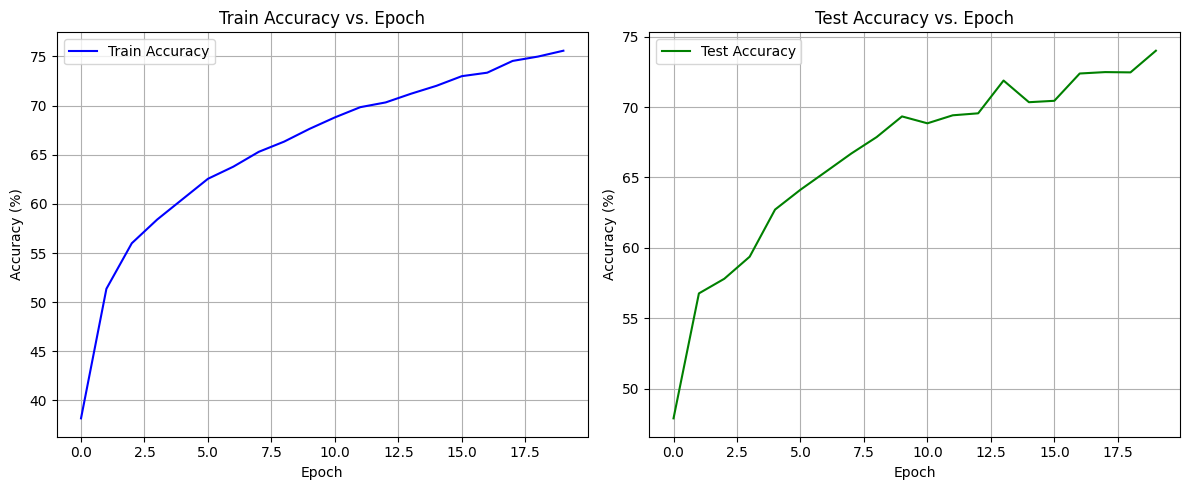

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(train_accuracy, label='Train Accuracy', color='blue')
axs[0].set_title('Train Accuracy vs. Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(test_accuracy, label='Test Accuracy', color='green')
axs[1].set_title('Test Accuracy vs. Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

##OBServation:
The MHSA based of VIT model do showed a better perofromence compare to MLP. Its head Q*Kt compute an attention scores to  be able to capture the relation among each patch and use the info for further predictions across entire images. The V matrix helps optimize the meaningful features through attention weights, helps contribute more informed decisions.

the training duration takes a longer than MLP

### 5.2 Generalization vs Memorization [7 pts]

In this experiment, we explore the capacity of deep neural networks to memorize arbitrary data by training a model on randomly shuffled labels. Both the training and test labels are randomized. The goal is to observe the model’s behavior when trained and tested on randomly shuffled labels.

**Your model should be able to memorize the random training data. That means you should achieve high training accuracy.**


For more details on label randomization experiments, refer to [2].


**Reference**
[2] Zhang, Chiyuan, et al. "Understanding deep learning requires rethinking generalization." International Conference on Learning Representations. 2022.

#### Dataset and dataloader setup

Here, we will create a dataset that has random labels.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


random_train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
random_test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Apply random labels to the datasets
num_classes = 10
random_train_data.targets = np.random.randint(0, num_classes, size=len(random_train_data))
random_test_data.targets = np.random.randint(0, num_classes, size=len(random_test_data))

# To make the training simpler, let us subsample the dataset and pick only 5000 training and 500 test images
train_subset_indices = torch.randperm(len(random_train_data))[:5000]
test_subset_indices = torch.randperm(len(random_test_data))[:500]

random_train_data = Subset(random_train_data, train_subset_indices)
random_test_data = Subset(random_test_data, test_subset_indices)

batch_size = 8
random_train_loader = DataLoader(random_train_data, batch_size=batch_size, shuffle=True)
random_test_loader = DataLoader(random_test_data, batch_size=batch_size)

#### 5.2.1 Implement training and evaluation [3 pts]

Write a training loop similar to ***Question 5.1.2*** but instead use `random_train_loader` and `random_test_loader` data loaders.

**Make sure to create a new model object.**


Compute and store both test accuracy and training accuracy for this randomized experiment at every epoch.

**Hint**. Your model should be large enough to memorize training data.

In [ ]:
# Define model
model_random_labels = VisionTransformer(
    num_heads=8,
    num_layers=4,
    hidden_dim=256,
    num_classes=10,
    patch_size=4,
    in_channels=3,
    img_size=32,
    mlp_hidden_dim=256 * 4,
    attn_drop_out=0.1
)

In [ ]:
# TODO
# Write training loop

# Define the optimizer and loss function
learning_rate = 2e-4
num_epochs = 20
optimizer = torch.optim.Adam(model_random_labels.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Move model to cuda if available
if torch.cuda.is_available():
  model_random_labels.cuda()

train_accuracy_random = []
test_accuracy_random = []

# Training loop
for epoch in range(num_epochs):
    model_random_labels.train()

    running_loss = 0.0

    correct_train = 0
    total_train = 0

    for inputs, targets in random_train_loader:
        # Move data to device if cuda is available
        if torch.cuda.is_available():
          inputs, targets = inputs.cuda(), targets.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # TODO:
        # Fill the following sections

        # Forward pass
        outputs = model_random_labels(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward propagation on the loss
        loss.backward()

        # Update model parameters using optimizer
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation for train set
        predicted = outputs.argmax(dim=1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    train_acc = 100 * correct_train / total_train
    train_accuracy_random.append(train_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss / len(random_train_loader):.4f} Train Acc: {train_acc:.2f}%')

    # Evaluation
    model_random_labels.eval()

    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, targets in random_test_loader:
            # Move data to device if cuda is available
            if torch.cuda.is_available():
              inputs, targets = inputs.cuda(), targets.cuda()

            # TODO:
            # Fill the following sections

            # Forward pass
            outputs = model_random_labels(inputs)

            # Get predictions
            predicted = outputs.argmax(dim=1)

            correct_test += (predicted == targets).sum().item()
            total_test += targets.size(0)

    # TODO:
    # Compute accuracy on the test set
    test_acc = 100 * correct_test / total_test
    test_accuracy_random.append(test_acc)
    print(f"Test Acc: {test_acc:.2f}%")

Epoch [1/20] Loss: 2.4193 Train Acc: 10.20%
Test Acc: 11.60%
Epoch [2/20] Loss: 2.3568 Train Acc: 10.24%
Test Acc: 10.00%
Epoch [3/20] Loss: 2.3387 Train Acc: 9.38%
Test Acc: 9.60%
Epoch [4/20] Loss: 2.3378 Train Acc: 9.22%
Test Acc: 10.80%
Epoch [5/20] Loss: 2.3252 Train Acc: 10.46%
Test Acc: 9.20%
Epoch [6/20] Loss: 2.3256 Train Acc: 10.08%
Test Acc: 12.60%
Epoch [7/20] Loss: 2.3240 Train Acc: 10.48%
Test Acc: 12.20%
Epoch [8/20] Loss: 2.3199 Train Acc: 11.36%
Test Acc: 11.60%
Epoch [9/20] Loss: 2.3151 Train Acc: 11.82%
Test Acc: 10.60%
Epoch [10/20] Loss: 2.3141 Train Acc: 11.12%
Test Acc: 9.40%
Epoch [11/20] Loss: 2.3076 Train Acc: 12.00%
Test Acc: 12.40%
Epoch [12/20] Loss: 2.2965 Train Acc: 13.16%
Test Acc: 9.80%
Epoch [13/20] Loss: 2.2826 Train Acc: 14.00%
Test Acc: 7.80%
Epoch [14/20] Loss: 2.2632 Train Acc: 15.66%
Test Acc: 10.60%
Epoch [15/20] Loss: 2.2430 Train Acc: 17.14%
Test Acc: 9.80%
Epoch [16/20] Loss: 2.2074 Train Acc: 18.68%
Test Acc: 8.40%
Epoch [17/20] Loss: 2.1650

#### 5.2.3 Plot training and test accuracy for the randomized training. [2pts]


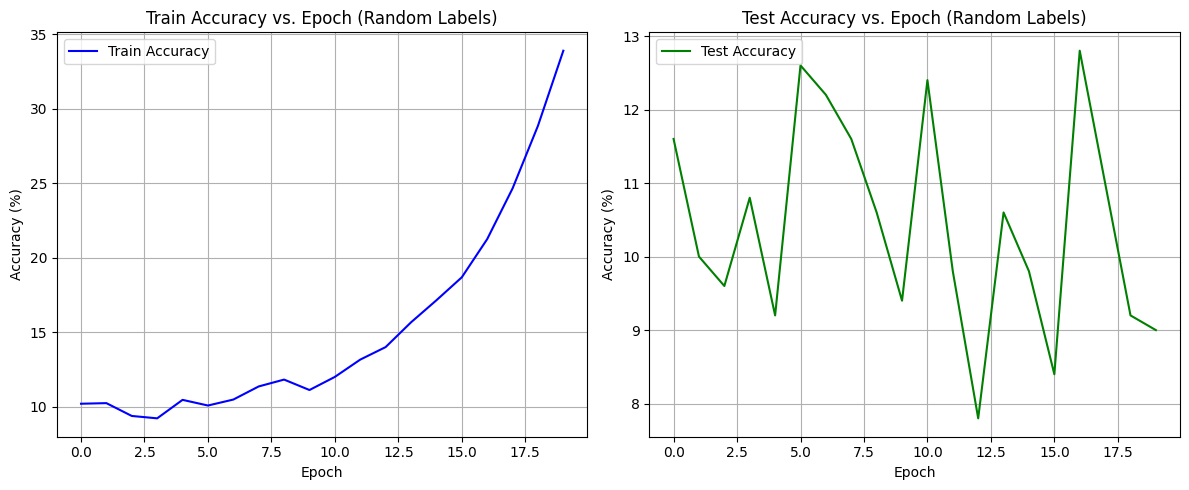

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(train_accuracy_random, label='Train Accuracy', color='blue')
axs[0].set_title('Train Accuracy vs. Epoch (Random Labels)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(test_accuracy_random, label='Test Accuracy', color='green')
axs[1].set_title('Test Accuracy vs. Epoch (Random Labels)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


#### 5.2.4 Generalization Capability of the Model [2 pts]

Discuss your observations during the randomization test. What did you notice about the model's ability to fit the training data and generalize to the test set when trained on randomized labels?

**Answer:**
The model's training accuracy increase as epoch increases. And its doing better than random guess 10%. Indicating The model do able to capture essential features and memorize these patterns even if there is no real relation between features and targets.

However, the test accuracy remains around 10% which is similar to random guess on 10 different class samples. Which means the model unable to predict un-seen data. Despite it looks like overfitting, but since the training and test samples are randomized, the model theoritically should reach around at 10% accuracy  on test set but a high accuracy on training set.

In short, ViT_MHSA able to capture even random data patterns. And random training data sample can result a random guess on un-seen data

---

## **Submission instructions**
1. Download this Colab to ipynb, and convert it to PDF. Follow similar steps as [here](https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab) but convert to PDF.
 - Download your .ipynb file. You can do it using only Google Colab. `File` -> `Download` -> `Download .ipynb`
 - Reupload it so Colab can see it. Click on the `Files` icon on the far left to expand the side bar. You can directly drag the downloaded .ipynb file to the area. Or click `Upload to session storage` icon and then select & upload your .ipynb file.
 - Conversion using %%shell.
 ```
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc
!pip install pypandoc
!jupyter nbconvert --log-level CRITICAL --to pdf name_of_hw.ipynb
  ```
 - Your PDF file is ready. Click 3 dots and `Download`.
**Note: Please follow these instructions to generate the PDF. Do not use any other method, such as `ctrl+p`.**

2. Upload the PDF to elearn and **select** the correct pages for each question. Refer to the week 1 discussion video or contact the TAs if you face any issues. **Important!**


3. Upload the `.ipynb` file to elearn. Make sure that both the **code** and the **PDF** are uploaded. **Important!**


Notice: In case of errors in conversion, please check your LaTeX and debug. In Markdown, when you write in LaTeX math mode, do not leave any leading and trailing whitespaces inside the dollar signs ($). For example, write `(dollarSign)\mathbf(dollarSign)(dollarSign)` instead of `(dollarSign)(space)\mathbf{w}(dollarSign)`. Otherwise, nbconvert will throw an error and the generated pdf will be incomplete.

In [ ]:
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc
!pip install pypandoc

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,154 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,543 kB]
Get:13 https://developer.download.nvidia.com/compute/cuda/

In [ ]:
!jupyter nbconvert --log-level INFO --to pdf Spring2025_hw1_submissionYurui.ipynb # make sure the ipynb name is correct

[NbConvertApp] Converting notebook Spring2025_hw1_submissionYurui.ipynb to pdf
[NbConvertApp] Support files will be in Spring2025_hw1_submissionYurui_files/
[NbConvertApp] Making directory ./Spring2025_hw1_submissionYurui_files
[NbConvertApp] Writing 155408 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 327856 bytes to Spring2025_hw1_submissionYurui.pdf
